# CS541 Applied Machine Learning Spring 2025 - Class Challenge

In this class challenge assignment, you will be building a machine learning model to predict the price of an Airbnb rental, given the dataset we have provided. Total points: **100 pts**

To submit your solution, you need to submit a python (.py) file named challenge.py on Gradescope.
Initial Submission due on April 22, 2025
Final Submission due May 1, 2025

The top-3 winners will present their methodology on the last day of class (May 1st). Instructions on the presentation to follow.

There will be a Leaderboard for the challenge that can be seen by all students. USE YOUR FULL NAME AND NO NICKNAMES.

To encourage you to get started early on the challenge, you are required to submit an initial submission due on **April 22**. For this submission, your model needs to achieve a MSE of 0.16 or lower denoted as Baseline1.csv in the Kaggle Leaderboard. The final submission will be due on **May 1**.


## Problem and dataset description
Pricing a rental property such as an apartment or house on Airbnb is a difficult challenge. A model that accurately predicts the price can potentially help renters and hosts on the platform make better decisions. In this assignment, your task is to train a model that takes features of a listing as input and predicts the price.

We have provided you with a dataset collected from the Airbnb website for New York, which has a total of 29,985 entries, each with 765 features. You may use the provided data as you wish in development. We will train your submitted code on the same provided dataset, and will evaluate it on 2 other test sets (one public, and one hidden during the challenge).

We have already done some minimal data cleaning for you, such as converting text fields into categorical values and getting rid of the NaN values. To convert text fields into categorical values, we used different strategies depending on the field. For example, sentiment analysis was applied to convert user reviews to numerical values ('comments' column). We added different columns for state names, '1' indicating the location of the property. Column names are included in the data files and are mostly descriptive.

Also in this data cleaning step, the price value that we are trying to predict is calculated by taking the log of original price. Hence, the minimum value for our output price is around 2.302 and maximum value is around 9.21 on the training set.


## Datasets and Codebase

Please download the zip file from the link posted on Piazza/Resources.
In this notebook, we implemented a linear regression model with random weights (**attached in the end**). For datasets, there’re 2 CSV files for features and labels:

    challenge.ipynb (This file: you need to add your code in here, convert it to .py to submit)
    data_cleaned_train_comments_X.csv
    data_cleaned_train_y.csv


## Instructions to build your model
1.  Implement your model in **challenge.ipynb**. You need to modify the *train()* and *predict()* methods of **Model** class (*attached at the end of this notebook*). You can also add other methods/attributes  to the class, or even add new classes in the same file if needed, but do NOT change the signatures of the *train()* and *predict()* as we will call these 2 methods for evaluating your model.

2. To submit, you need to convert your notebook (.ipynb) to a python **(.py)** file. Make sure in the python file, it has a class named **Model**, and in the class, there are two methods: *train* and *predict*. Other experimental code should be removed if needed to avoid time limit exceeded on gradescope.

3.  You can submit your code on gradescope to test your model. You can submit as many times you like. The last submission will count as the final model.

An example linear regression model with random weights is provided to you in this notebook. Please take a look and replace the code with your own.


## Evaluation

We will evaluate your model as follows

    model = Model() # Model class imported from your submission
    X_train = pd.read_csv("data_cleaned_train_comments_X.csv")  # pandas Dataframe
    y_train = pd.read_csv("data_cleaned_train_y.csv")  # pandas Dataframe
    model.train(X_train, y_train) # train your model on the dataset provided to you
    y_pred = model.predict(X_test) # test your model on the hidden test set (pandas Dataframe)
    mse = mean_squared_error(y_test, y_pred) # compute mean squared error


**There will be 2 test sets, one is public which means you can see MSE on this test set on the Leaderboard (denoted as *MSE (PUBLIC TESTSET)*), and the other one is hidden during the challenge (denoted as *MSE (HIDDEN TESTSET)*)**.
Your score on the hidden test set will be your performance measure. So, don’t try to overfit your model on the public test set. Your final grade will depend on the following criteria:


1.  	Is it original code (implemented by you)? Use of Generative AI to generate code will be flagged as academic misconduct and will be reported to the Academic Conduct Committee (ACC)
2.  	Does it take a reasonable time to complete?
    Your model needs to finish running in under 40 minutes on our machine. We run the code on a machine with 4 CPUs, 6.0GB RAM.
3.  	Does it achieve a reasonable MSE?
    - **Initial submission (10 pts)**: Your model has to be better than the simplest model results which should be a MSE of 0.16 or lower denoted as Baseline1.csv in the leaderboard. Note this will due on **April 22**.
    
    The grade will be linearly interpolated for the submissions that lie in between the checkpoints above. We will use MSE on the hidden test set to evaluate your model (lower is better).

    **Bonus**: **Top 3** with the best MSE on the hidden test set will get a 5 point bonus.

# Answer the below questions (in the final submission due on May 1st)

1. What are the top-5 features contributed the most towards the performance? How did you identify these features? Your answer should be between 300-350 words.

    To identify the top-5 features that contributed the most to the model’s performance, I used the SelectKBest feature selection method combined with the f_regression scoring function. This method computes the strength of the linear relationship between each feature and the target variable "price" and assigns a corresponding F-score. A higher F-score implies a stronger statistical association and, consequently, a greater contribution to the model’s predictive power.

    Feature selection is a crucial step in machine learning, especially when working with such high-dimensional datasets. It helps improve model performance by eliminating irrelevant or weakly related features, reducing overfitting risks, and speeding up training. I chose SelectKBest because it offers a simple yet effective approach to evaluate each feature individually. By using f_regression as the scoring function, I ensured that the selection was purely based on statistical relevance. This approach allows the most predictive features to be selected based solely on their intrinsic correlation with the target variable.

    After fitting the selector on the training data, I sorted all features by their F-scores in descending order. The top-5 features with the highest scores are "Entire home/apt," "Private room," "accommodates," "beds," and "Manhattan". These features are quite intuitive when considering real-world factors that influence rental prices, especially in New York City.

    "Entire home/apt" and "Private room" represent the type of property being listed, which greatly affects pricing. Listings offering an entire property tend to command significantly higher prices compared to those offering only private rooms. "Accommodates" and "beds" are quantitative features that indicate how many guests a property can host, directly impacting its rental value. The more guests a property can accommodate, the greater the potential income for the host. Similarly, the number of beds reflects how many people can comfortably stay at the property, which is highly relevant for group travelers.

    "Manhattan" is a boolean feature of whether a property is located in Manhattan, the most expensive area in New York City. Properties located in Manhattan typically have much higher rental prices compared to those in other areas, so it makes sense that this feature would have a strong influence on the model’s predictions.

    Overall, the top-5 features identified are not only statistically significant but also align well with commen sense about the Airbnb rental market with the feature selection method.

2. What are the top-5 features contributed the least towards the performance? Your answer should be between 300-350 words.

    To determine the top-5 features that contributed the least to the model’s performance, I again used the SelectKBest feature selection method combined with the f_regression scoring function. After fitting the selector on the training data, I sorted all features in ascending order based on their F-scores, identifying those with the weakest relationship with the target variable "price"

    The bottom-5 features with the lowest F-scores were "Springfield Gardens", "RIDGEWOOD" "Ny", "Kew Gardens Hills", and "South Ozone Park". Each of these features exhibited an F-score of approximately 0.828, indicating an extremely weak linear association with rental price predictions. Notably, all these features represent specific neighborhood names or location indicators within New York City.

    Although location is typically a important factor in real estate valuation, these particular neighborhoods likely showed minimal variation in price relative to other areas or lacked sufficient representation in the dataset. As a result, the model found very little predictive value from these features. Additionally, some features, such as “Ny,” appear to be incomplete or poorly defined. When I inspected the dataset, I found that "Ny" column has almost all 0s, so I assumed it could be a mistype, thus it is a useless feature and of course a low-contributing feature.

    Low-contributing features like these can introduce noise, increase model complexity unnecessarily, and potentially lead to overfitting if not properly managed. By identifying them early through statistical analysis, we can ensure the model focuses only on the features that provide meaningful information about the target variable.

    Choosing SelectKBest with f_regression allowed for a purely data-driven feature evaluation, independent of any specific model biases. This ensures that the determination of low-importance features is based solely on objective statistical relevance.

    In conclusion, the bottom-5 features were selected based on their minimal F-scores, reflecting their negligible contribution to the predictive performance of the model. Their removal can simplify the model and improve both interpretability and training efficiency without sacrificing accuracy.


3. Share the training and validation loss plots
Title of the plot should indicate the number of training / validation data points used.

    The plot is in cell below. Please run the code to generate the plot.

# Notes & Code

**Note 1: This is a regression problem** in which we want to predict the price for an AirBnB property. You should try different models and finetune their hyper parameters.  A little feature engineering can also help to boost the performance.

**Note 2**: You may NOT use additional datasets. This assignment is meant to challenge you to build a better model, not collect more training data, so please only use the data we provided. We tested the code on Python 3.10 and 3.9, thus it’s highly recommended to use these Python versions for the challenge.


In this challenge, you can only use built-in python modules, and these following:
- Numpy
- pandas
- scikit_learn
- matplotlib
- scipy
- torchsummary
- xgboost
- torchmetrics
- lightgbm
- catboost
- torch



In [14]:
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import DMatrix, train as xgb_train
import matplotlib.pyplot as plt

class Model:
    def __init__(self):
        self.feature_selecter = None
        self.model = None
        self.k_features = 111
        self.xgb_params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'eta': 0.0045,                  
            'max_depth': 6,                  
            'colsample_bytree': 0.6,      
            'min_child_weight': 40,          
            'alpha': 2.3,                
            'lambda': 0.065,           
            'subsample': 0.8,               
            'seed': 42
        }
        self.evals_result = {}
        self.early_stopping_rounds = 20
        self.num_boost_round = 5000         

    def train(self, X_train: pd.DataFrame, y_train: pd.DataFrame) -> None:
        if 'id' in X_train.columns:
            X_train = X_train.drop(columns=['id'])

        y_train = y_train['price']

        self.feature_selecter = SelectKBest(score_func=f_regression, k=self.k_features)
        X_selected = self.feature_selecter.fit_transform(X_train, y_train)

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_selected, y_train, test_size=0.1, random_state=42
        )

        dtrain = DMatrix(X_tr, label=y_tr)
        dval = DMatrix(X_val, label=y_val)

        self.model = xgb_train(
            self.xgb_params,
            dtrain,
            num_boost_round=self.num_boost_round,
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=self.early_stopping_rounds,
            evals_result=self.evals_result,
            verbose_eval=False
        )

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        if 'id' in X_test.columns:
            X_test = X_test.drop(columns=['id'])
        X_selected = self.feature_selecter.transform(X_test)
        dtest = DMatrix(X_selected)
        y_pred = self.model.predict(dtest)
        return y_pred.reshape(-1, 1)
    
    def get_feature_importance(self, X_train: pd.DataFrame) -> pd.DataFrame:
        feature_names = [col for col in X_train.columns if col != 'id']

        selected = self.feature_selecter.get_support()
        selected_feature_names = np.array(feature_names)[selected]
        scores = self.feature_selecter.scores_[selected]

        feature_score_df = pd.DataFrame({
            'feature': selected_feature_names,
            'score': scores
        })

        feature_score_df_sorted = feature_score_df.sort_values(by='score', ascending=False).reset_index(drop=True)

        top5_features = feature_score_df_sorted.head(5)
        bottom5_features = feature_score_df_sorted.tail(5)

        print("Top-5 Most Important Features:")
        print(top5_features)

        print("\nTop-5 Least Important Features:")
        print(bottom5_features)

        return feature_score_df_sorted

    def plot_loss(self, X_train: pd.DataFrame) -> None:
        train_mse_list =[x**2 for x in self.evals_result['train']['rmse']]
        val_mse_list = [x**2 for x in self.evals_result['eval']['rmse']]

        plt.figure(figsize=(10, 6))
        plt.plot(train_mse_list, label='Train MSE')
        plt.plot(val_mse_list, label='Validation MSE')
        plt.xlabel('Boosting Rounds')
        plt.ylabel('MSE')
        plt.title(f"Training (n={len(X_train) * 0.9:.0f}) / Validation (n={len(X_train) * 0.1:.0f}) Loss Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

## Local Test

In [15]:
X = pd.read_csv("./trainData.csv")
y = pd.read_csv("./trainLabel.csv")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
model = Model()
model.train(X_train, y_train)

y_pred_train = model.predict(X_train)
train_mse = mean_squared_error(y_train['price'], y_pred_train)
print(f"Train MSE: {train_mse:.4f}")
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val['price'], y_pred)
print(f"Valid MSE: {mse:.4f}")
print(f"Valid MSE - Train MSE: {mse - train_mse:.4f}")


Train MSE: 0.1116
Valid MSE: 0.1327
Valid MSE - Train MSE: 0.0211


## Submission

In [16]:
model = Model() # Model class imported from your submission
X_train = pd.read_csv("./trainData.csv")  # pandas Dataframe
y_train = pd.read_csv("./trainLabel.csv")  # pandas Dataframe
model.train(X_train, y_train) # train your model on the dataset provided to you
X_test = pd.read_csv("./testingData.csv") # pandas Dataframe
y_pred = model.predict(X_test) # test your model on the hidden test set (pandas Dataframe)

# Print training MSE
y_pred_train = model.predict(X_train)
train_mse = mean_squared_error(y_train['price'], y_pred_train)
print(f"Train MSE: {train_mse:.4f}")


submission = pd.DataFrame({
    'id': X_test['id'],
    'price': y_pred.flatten()
})
submission.to_csv("./submission.csv", index=False)

Train MSE: 0.1116


## Feature Importance

In [17]:
model.get_feature_importance(X_train)

Top-5 Most Important Features:
           feature         score
0  Entire home/apt  19366.024424
1     Private room  15295.851894
2     accommodates  13647.888985
3             beds   6393.069316
4        Manhattan   4317.450870

Top-5 Least Important Features:
                         feature      score
106  review_scores_communication  86.411148
107                   Flushing.1  85.143685
108       review_scores_accuracy  84.982376
109            Flatiron District  84.383700
110                    Brooklyn   84.334750


,feature,score
0,Entire home/apt,19366.024424
1,Private room,15295.851894
2,accommodates,13647.888985
3,beds,6393.069316
4,Manhattan,4317.450870
...,...,...
106,review_scores_communication,86.411148
107,Flushing.1,85.143685
108,review_scores_accuracy,84.982376
109,Flatiron District,84.383700


## Training and Validation plots

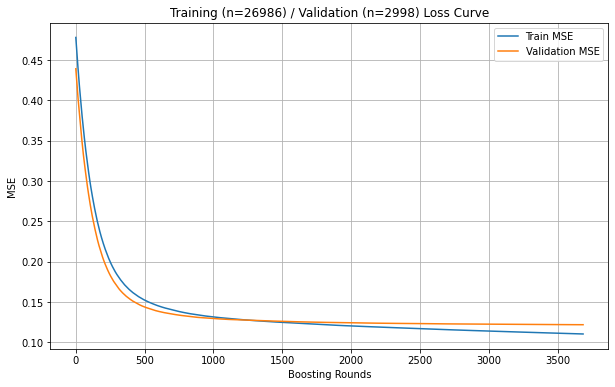

In [18]:
model.plot_loss(X_train)

**GOOD LUCK!**
